# Eliminación de fondo usando SVD

Queremos eliminar el fondo de un video utilizando la descomposición en valores singulares (SVD). La idea es que los componentes principales (valores singulares más grandes) capturan la mayor parte de la información de la imagen, mientras que los componentes con valores singulares más pequeños suelen corresponder al ruido o al fondo.

Primero importamos las librerías necesarias y descargamos el video:

In [1]:
import urllib.request
import zipfile
import os
import moviepy.editor as mpe
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
# Descargar el archivo
url = 'http://backgroundmodelschallenge.eu/data/real/Video_003.zip'
output = 'data/Video_003.zip'
urllib.request.urlretrieve(url, output)

# Descomprimir el archivo
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('data/')

Cargamos el video y vemos sus características básicas:

In [2]:
video = mpe.VideoFileClip("data/Video_003/Video_003.avi")
video.duration, video.fps, video.size

(113.57, 7.0, [320, 240])

Vemos un pequeño clip del video original:

In [3]:
clip = video.subclip(0,10)

clip.ipython_display(width=400)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:   0%|          | 0/70 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready __temp__.mp4


### Métodos auxiliares
Para poder trabajar con el video, necesitamos implementar un par de métodos auxiliares:
- un método para transformar una imagen en color a una imagen en escala de grises (SVD trabaja con matrices 2D, por lo que, para simplificar, evitamos repetir las mismas operaciones en cada canal usando una imagen en escala de grises);
- un método para transformar el video en una matriz de `numpy`. También reducimos la resolución del video para disminuir el costo computacional de aplicar el SVD. Podemos "desenrollar" un fotograma en una sola columna: en lugar de tener una imagen 2D, tenemos una columna. Esto no es muy legible para un humano, pero resulta útil porque nos permite apilar imágenes tomadas en distintos instantes una encima de la otra, colocando así todo el video dentro de una sola matriz.

In [4]:
def matriz_frames(clip, dims):
    n_frames = int(clip.fps * clip.duration)
    frames_aplanados = []
    for i in range(n_frames):
        # get_frame recibe como entrada el instante de tiempo del frame
        # p ej. para video de 30 fps, el frame i = 60 corresponde al segundo 2
        frame = clip.get_frame(i / clip.fps)
        # convertir a escala de grises
        frame_gris = np.mean(frame[..., :3], axis=-1).astype(int)
        # redimensionar para reducir el costo computacional
        frame_gris_pequeno = skimage.transform.resize(frame_gris, dims)
        # cada frame se convierte en un vector columna de A
        frames_aplanados.append(frame_gris_pequeno.flatten())
    return np.vstack(frames_aplanados).T


Definimos algunos parámetros y transformamos el video en una matriz de datos:

In [5]:
scale = 0.50   # Ajuste de la resolución
width, height = video.size
dims = (int(height * scale), int(width * scale)) # nueva dimensión de los frames
A = matriz_frames(video, dims)
print("Tamaño de cada frame:", dims)
print("Tamaño de la matriz del video:", A.shape)

Tamaño de cada frame: (120, 160)
Tamaño de la matriz del video: (19200, 794)


El tamaño de la matriz $A$ es `(n_pixels, n_frames)`. El parámetro `n_pixels` es el número de píxeles en cada fotograma (después de la reducción de resolución y este se corresponde a `dims[0]` $\times$ `dims[1]`, es decir, $120 \times 160 = 19200$) que se encuentran aplanados en cada columna. Mientras que `n_frames` es el número total de fotogramas en el video ($fps * duración$).

Vamos a visualizar algunos de los fotogramas del video original para entender mejor cómo se ve la matriz $A$:

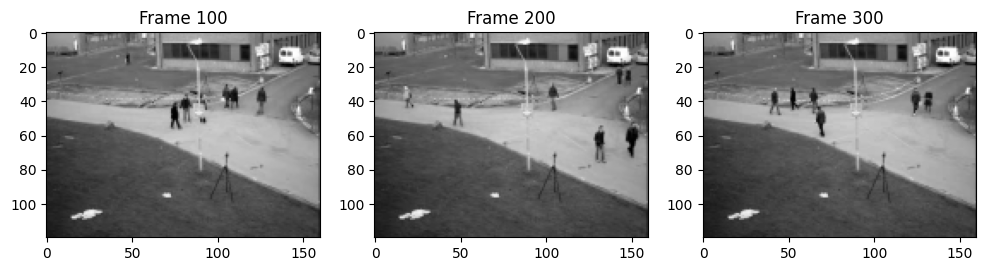

In [6]:
# Visualizamos los fotogramas 100, 200 y 300
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].set_title('Frame 100')
axs[0].imshow(np.reshape(A[:,100], dims), cmap='gray')
axs[1].set_title('Frame 200')
axs[1].imshow(np.reshape(A[:,200], dims), cmap='gray')
axs[2].set_title('Frame 300')
axs[2].imshow(np.reshape(A[:,300], dims), cmap='gray')

¿Y cómo se ve la matriz $A$ completa? Podemos visualizarla como una imagen en escala de grises, donde cada columna representa un fotograma del video:

Text(0, 0.5, 'Píxeles')

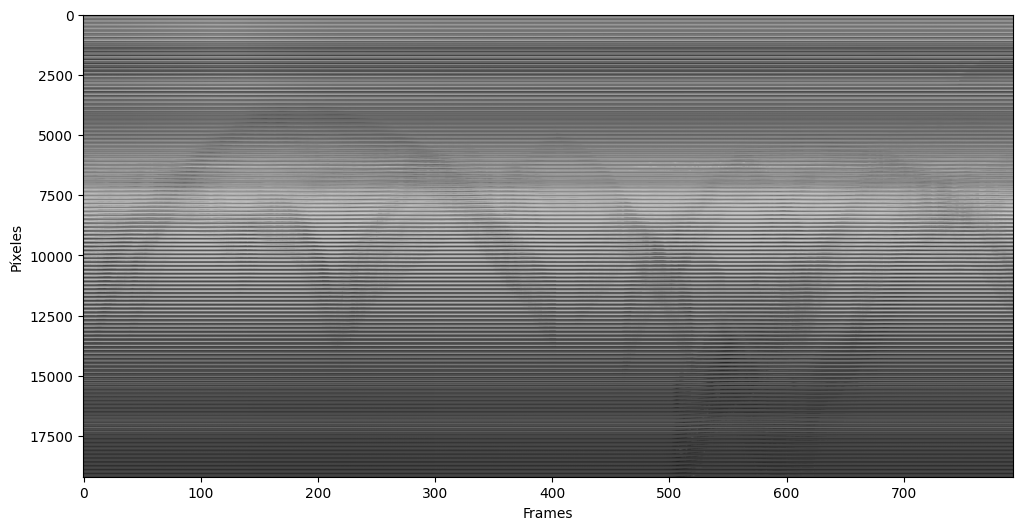

In [7]:
plt.figure(figsize=(12, 6))
plt.imshow(A, cmap='gray', aspect='auto') # aspect='auto' para ajustar la relación de aspecto
plt.xlabel('Frames')
plt.ylabel('Píxeles')

Las curvas que se ven en la imagen representan cambios en la intensidad de los píxeles a lo largo del tiempo (a medida que avanzan los fotogramas). 

Para reconstruir el fondo, como se mantiene constante a lo largo del video, podemos utilizar $SVD$ para identificar los componentes principales de la matriz $A$. 

Los primeros componentes (asociados a los valores singulares más grandes) deberían capturar el fondo. Mientras que los componentes asociados a valores singulares más pequeños deberían capturar los objetos en movimiento (primer plano), ya que estos cambian de un fotograma a otro.

## Aplicamos SVD

In [8]:
U, s, VT = np.linalg.svd(A, full_matrices=False)

Tal y como hemos comentado, el fondo se mantiene constante a lo largo del video, por lo que debería estar representado en los primeros componentes principales de la descomposición SVD de la matriz $A$. Probamos a reconstruir el fondo utilizando solo el primer componente principal (k=1).:

In [14]:
k = 1
fondo = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]

A continaución mostramos la matriz que contiene todos los fotogramas del fondo reconstruido:

Text(0, 0.5, 'Píxeles')

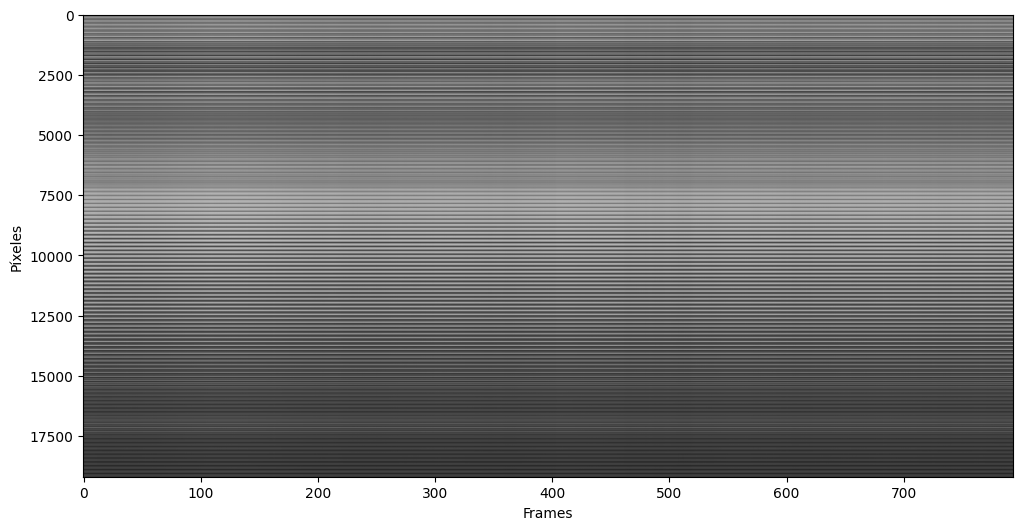

In [15]:
plt.figure(figsize=(12, 6))
plt.imshow(fondo, cmap='gray', aspect='auto') # aspect='auto' para ajustar la relación de aspecto
plt.xlabel('Frames')
plt.ylabel('Píxeles')

Como podemos ver, las curvas que representaban los cambios en la intensidad de los píxeles a lo largo del tiempo han desaparecido en gran medida, lo que indica que el fondo se ha reconstruido correctamente utilizando solo el primer componente principal.

Ahora mostramos el fondo reconstruido en 4 fotogramas diferentes:

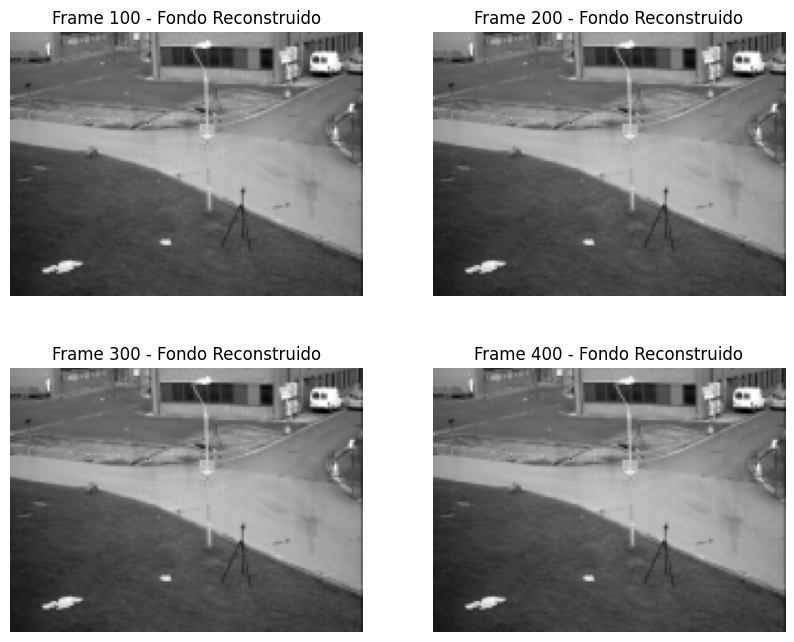

In [19]:
# Mostramos el fondo reconstruido en 4 fotogramas diferentes
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.reshape((-1,))
for i, frame_idx in enumerate([100, 200, 300, 400]):
    axs[i].set_title(f'Frame {frame_idx} - Fondo Reconstruido')
    axs[i].axis('off')
    axs[i].imshow(np.reshape(fondo[:, frame_idx], dims), cmap='gray')

El fondo se ha reconstruido bastante bien utilizando solo el primer componente principal (k=1). Los objetos en movimiento (las personas) ya no son visibles en estos fotogramas reconstruidos, aunque puede que queden algunos restos borrosos en algun frame, probablemente debido a que las personas no se movían rápidamente y, por tanto, su presencia afectaba ligeramente al fondo en esos fotogramas específicos.

Una vez que hemos reconstruido el fondo, podemos restarlo del video original para obtener el primer plano (las personas en movimiento), ya que al restar el fondo, los píxeles correspondientes a las personas deberían tener valores cercanos a cero en los fotogramas donde no están presentes, y valores más altos donde sí lo están.

A continuación mostramos algunos fotogramas del primer plano obtenido tras restar el fondo reconstruido del video original:

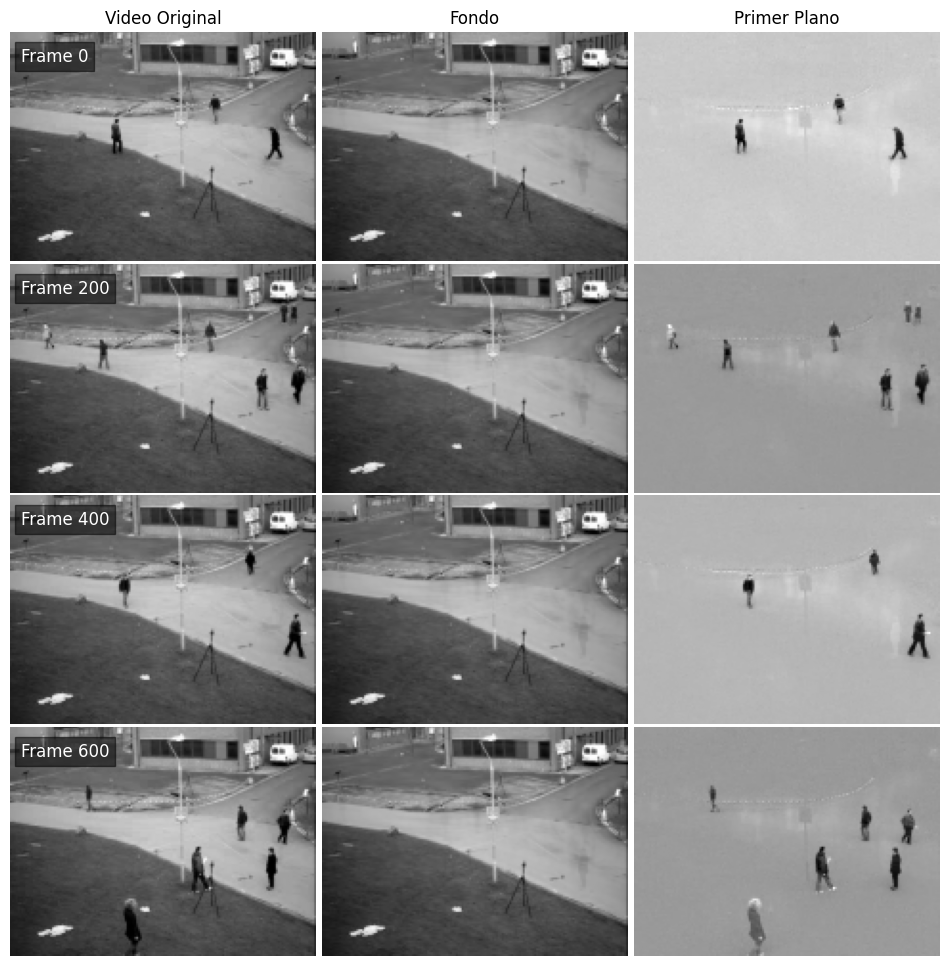

In [17]:
def plot_frames(A, fondo, num_frame):
    fig, axs = plt.subplots(len(num_frame), 3, figsize=(12, 3 * len(num_frame)))
    axs = axs.reshape((-1, 3))

    for i, t_id in enumerate(num_frame):

        # video original
        axs[i, 0].imshow(np.reshape(A[:, t_id], dims), cmap='gray')
        axs[i, 0].axis('off')

        # fondo
        axs[i, 1].imshow(np.reshape(fondo[:, t_id], dims), cmap='gray')
        axs[i, 1].axis('off')

        # primer plano
        axs[i, 2].imshow(np.reshape(A[:, t_id] - fondo[:, t_id], dims), cmap='gray')
        axs[i, 2].axis('off')

        # texto con el número de frame 
        axs[i, 0].text(
            5, 15, # posición del texto (esquina arriba izquierda)
            f"Frame {t_id}",
            color="white",
            fontsize=12,
            bbox=dict(facecolor="black", alpha=0.5)
        )

    # Títulos
    axs[0, 0].set_title("Video Original")
    axs[0, 1].set_title("Fondo")
    axs[0, 2].set_title("Primer Plano")

    # Reducir espacio entre imágenes
    plt.subplots_adjust(wspace=0.02, hspace=0.01)

    plt.show()



num_frame = [0, 200, 400, 600]
plot_frames(A, fondo, num_frame)

Como se puede ver en el frame $600$, una persona no ha sido eliminada del fondo. Esto se debe a que la persona se movía lentamente y quedó estática en ciertos momentos, por tanto, $SVD$ incluye a esa persona en los primeros valores singulares (como parte del fondo).

In [ ]:
# Número de frames a procesar
num_fps_out = 400

# Lista donde guardaremos los frames del primer plano en formato 2D
foreground_frames = []

for t in range(num_fps_out):
    # 1. Frame original aplanado
    frame_original = A[:, t]

    # 2. Su fondo correspondiente
    frame_fondo = fondo[:, t]

    # 3. Primer plano = original - fondo
    frame_fg = frame_original - frame_fondo

    # 4. Normalizar para evitar valores negativos o saturación
    #    Escalamos a rango 0-255 para poder formar un video
    frame_fg_norm = frame_fg - frame_fg.min()
    frame_fg_norm = frame_fg_norm / frame_fg_norm.max()
    frame_fg_norm = (frame_fg_norm * 255).astype(np.uint8)

    # 5. Volver a forma 2D (height, width)
    frame_2d = frame_fg_norm.reshape(dims)

    # 6. Guardar frame (nota: ImageSequenceClip requiere RGB)
    frame_rgb = np.stack([frame_2d]*3, axis=-1)  # escala de grises → 3 canales
    foreground_frames.append(frame_rgb)

# Crear el video a partir de los frames
fps_out = video.fps  # mantener mismo fps que el video original

clip_fg = mpe.ImageSequenceClip(foreground_frames, fps=fps_out)

# Mostrar el video
clip_fg.ipython_display(width=400, embed=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### Conclusiones:

1. La primera conclusión que hemos obtenido es que la descomposición en valores singulares (SVD) es una herramienta que puede llegar a funcionar para la eliminación de fondos en videos, especialmente cuando el fondo es estático y los objetos en movimiento son dinámicos. Al seleccionar adecuadamente el número de valores singulares a utilizar, podemos reconstruir el fondo de manera efectiva y aislar los objetos en movimiento en el primer plano. Sin embargo, es importante tener en cuenta que si los objetos en movimiento permanecen estáticos durante períodos prolongados, pueden ser incorporados al fondo reconstruido, lo que limita la eficacia del método en esos casos específicos.
2. La eliminación de fondo mediante descomposición en valores singulares (SVD) resulta computacionalmente costosa cuando trabajamos con videos, ya que implica factorizar una matriz de gran tamaño donde cada columna representa un fotograma aplanado. Para mitigar este coste, tuvimos que reducir la resolución del video. Aun así, el cálculo sigue siendo exigente, especialmente porque la SVD completa requiere tiempo y memoria significativos. Además, en la práctica solo utilizamos una fracción mínima de toda la descomposición (por ejemplo, los dos primeros valores singulares), lo que implica que la mayoría del cómputo realizado termina siendo descartado. Esto resalta que, aunque la SVD puede funcionar conceptualmente para separar fondo y primer plano, no es una herramienta eficiente para videos completos a gran escala y existen métodos más adecuados para aplicaciones en tiempo real o de mayor volumen.